In [2]:
# Compare detections of marine mammal vocalizations to  Sea Surface Temperature.

# Specifically, look at the ADEON EN615 deployment off Cape Hatteras, from 
# November 2017 to June 2018. 

# For marine mammal vocalizations, get a csv file of whistle detections from analyzing 
# (elsewhere) the high-frequency hydrophone data from this cruise, available at NCEI. 

# For SST, get a csv file from NASA JPL's GHRSST Level 4 MUR Global Foundation 
# Sea Surface Temperature Analysis.

# Convert the SST dataframe into a geodataframe and then save it to a shapefile
# to be integrated into an ArcGIS map.


In [ ]:
import pandas as pd
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# ArcGIS imports
import arcgis
from arcgis import geometry
from arcgis.geometry import Geometry
from arcgis.gis import GIS
from arcgis.geocoding import geocode
from arcgis.raster.functions import stretch, extract_band, apply, composite_band, colormap, remap, ndvi, NDVI


In [17]:
# Downloaded csv of SST using url: 
# https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41.csv?analysed_sst[(2017-11-24T09:00:00Z):1:(2018-06-18T09:00:00Z)][(34.5):1:(35.75)][(-76.5):1:(-74)],analysis_error[(2017-11-24T09:00:00Z):1:(2018-06-18T09:00:00Z)][(34.5):1:(35.75)][(-76.5):1:(-74)],mask[(2017-11-24T09:00:00Z):1:(2018-06-18T09:00:00Z)][(34.5):1:(35.75)][(-76.5):1:(-74)]
# Note that the 2nd line of the csv file was removed.


In [18]:
# Load SST csv file into pandas dataframe
# df_sst = pd.read_csv('jplMURSST41_6956_80b0_6cc6.csv', header=1)
df_sst = pd.read_csv('jplMURSST41_0528_e323_ab75.csv', header=0)

In [19]:
df_sst.head()

,time,latitude,longitude,analysed_sst,analysis_error,mask
0,2017-11-24T09:00:00Z,34.5,-76.50,18.807,0.4,1
1,2017-11-24T09:00:00Z,34.5,-76.49,18.872,0.4,1
2,2017-11-24T09:00:00Z,34.5,-76.48,18.937,0.4,1
3,2017-11-24T09:00:00Z,34.5,-76.47,19.003,0.4,1
4,2017-11-24T09:00:00Z,34.5,-76.46,19.069,0.4,1


In [20]:
# Convert to datetime like
df_sst['ts_UTC'] = pd.to_datetime(df_sst['time'], format='%Y-%m-%dT%H:%M:%SZ')

In [21]:
# Check datatypes
df_sst.info()
df_sst.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6546582 entries, 0 to 6546581
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   time            object        
 1   latitude        float64       
 2   longitude       float64       
 3   analysed_sst    float64       
 4   analysis_error  float64       
 5   mask            int64         
 6   ts_UTC          datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 349.6+ MB


,time,latitude,longitude,analysed_sst,analysis_error,mask,ts_UTC
0,2017-11-24T09:00:00Z,34.5,-76.50,18.807,0.4,1,2017-11-24 09:00:00
1,2017-11-24T09:00:00Z,34.5,-76.49,18.872,0.4,1,2017-11-24 09:00:00
2,2017-11-24T09:00:00Z,34.5,-76.48,18.937,0.4,1,2017-11-24 09:00:00
3,2017-11-24T09:00:00Z,34.5,-76.47,19.003,0.4,1,2017-11-24 09:00:00
4,2017-11-24T09:00:00Z,34.5,-76.46,19.069,0.4,1,2017-11-24 09:00:00


In [22]:
# Get the SST directly over the mooring
df_sst_over_mooring = df_sst.query("latitude==35.2 & longitude==-75.0")
#df_sst_over_mooring.head()
#df.dtypes

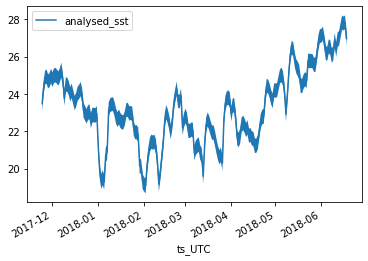

In [37]:
# Plot SST
df_sst_over_mooring.plot(x='ts_UTC',y='analysed_sst')
# Add error to plot
t = df_sst_over_mooring['ts_UTC']
sst = df_sst_over_mooring['analysed_sst']
sst_error = df_sst_over_mooring['analysis_error']
plt.fill_between(t, sst-sst_error, sst+sst_error)

In [24]:
# Elsewhere, I analyzed ADEON EN615 deployment at Cape Hatteras to detect 
# whistles, using Silbido. This analysis yielded a csv file with the following features: 
# bottom temperature (at a depth of about 290m) and a measure of the amount of whistling 
# per recording interval
df_whistles = pd.read_csv('whistles_ADEON.csv', header=0)
df_whistles.head()


,time,degrees_C_Bottom,fraction_Whistling
0,2017-11-24T14:18:56Z,NaN,0.00
1,2017-11-24T14:39:56Z,10.27,0.00
2,2017-11-24T15:00:56Z,10.28,0.00
3,2017-11-24T15:21:56Z,10.30,0.00
4,2017-11-24T15:42:56Z,10.33,0.02


In [25]:
# Convert to datetime like
# df['Time stamp'] = pd.to_datetime(df['Time stamp'], format= '%d/%m/%Y')
df_whistles['ts_UTC'] = pd.to_datetime(df_whistles['time'].str.strip(), format='%Y-%m-%dT%H:%M:%SZ')
#df_whistles.head()


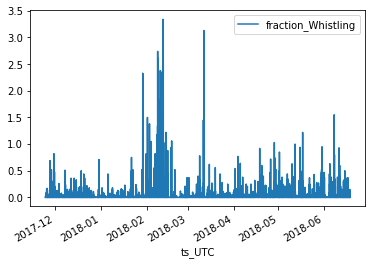

In [26]:
# Plot
df_whistles.plot(x='ts_UTC',y='fraction_Whistling')



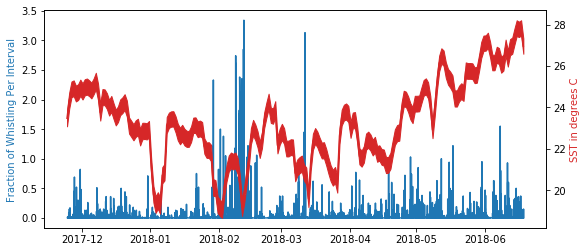

In [38]:
# Is there a relationship between the amount of whistling and the SST? 
# Start by plotting them together
fig, ax1 = plt.subplots(figsize=(9,4))
# Whistles
color1 = 'tab:blue'
ax1.plot(df_whistles['ts_UTC'],df_whistles['fraction_Whistling'], color=color1)
ax1.set_ylabel('Fraction of Whistling Per Interval', color=color1)
# SST
color2 = 'tab:red'
ax2 = ax1.twinx()
ax2.plot(df_sst_over_mooring['ts_UTC'],df_sst_over_mooring['analysed_sst'], color=color2)
ax2.set_ylabel('SST in degrees C', color=color2)
plt.fill_between(t, sst-sst_error, sst+sst_error, color=color2)




In [29]:
# There were 4 events (in Winter 2018) where the SST dropped below 20. 
# During 3 of these events, the fraction of whistling was very high.

In [30]:
# Add geometry to the pandas df_sst dataframe and create a geodataframe
df_sst['geometry'] = df_sst.apply(lambda row: Point(row.longitude, row.latitude), axis=1) 
df_sst = gpd.GeoDataFrame(df_sst, crs={'init' :'epsg:4326'})

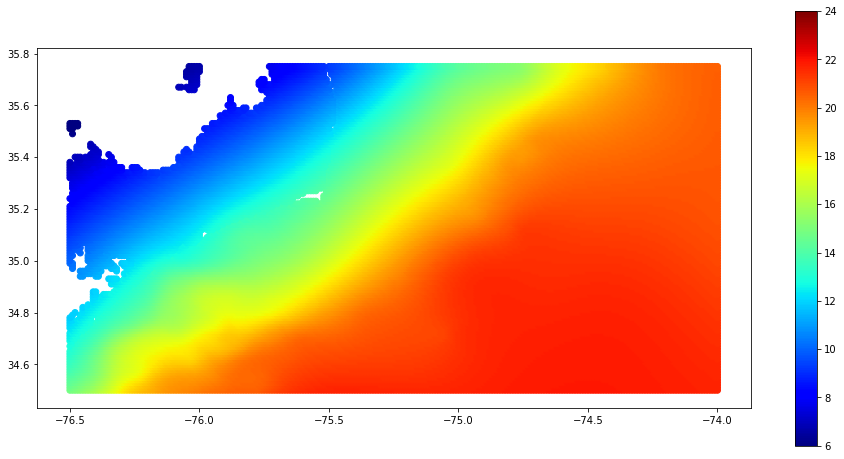

In [88]:
# Plot SST field at a specified (datetime) ts_UTC
# Pick a time when there are a lot of vocalizations AND the SST is low.
# In this first snapshot, we look at 2/1/2018.
df_sst_snapshot = df_sst.loc[lambda df_sst: df_sst['ts_UTC'] == '2018-02-01 09:00:00']
df_sst_snapshot_H20 = df_sst_snapshot.loc[lambda df_sst_snapshot: df_sst_snapshot['mask'] == 1]
df_sst_snapshot_H20.head()
df_sst_snapshot_H20.plot(column='analysed_sst', legend=True, figsize=(16,8), cmap='jet', vmin=6, vmax=24);



In [40]:
# It looks like the mooring location (35.2N, -75.0E) is at a frontal boundary 
# at this time (when there is a lot of vocalizations). In fact, this is true for
# all three high-vocalization, low SST events in the winter of 2018. They all occur
# when there is a strong SST gradient directly over the mooring location.

In [71]:
# The next step is to integrate with a map, showing mooring locations.
# Remove my actual userid and passwd before sharing the code.
gis = GIS(username="myuserid", password="mypasswd")
#gis.properties

In [85]:
# Before saving the SST snapshot to an ESRI shape file, we must remove
# the datetime columns
#df_sst_snapshot_H20.info()
#help(df_sst_snapshot_H20.to_file)
df_sst_snapshot_H20_sansDT = df_sst_snapshot_H20.drop(columns=['ts_UTC'])


In [87]:
# Save SST snapshot to ESRI shapefile
df_sst_snapshot_H20_sansDT.to_file("sst_ADEON.shp")



In [36]:
# Save SST over mooring (time series) to a csv file
df_sst_over_mooring.to_csv('sst_over_mooring_ADEON1.csv')